# Analytics

#### Date: 2021/02

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2021/02
##### Professor: Hilmer Neri

##### Members:

- Gabriel Alves Hussein 17/0103200
- Rafael Ribeiro de Oliveira 15/0045182
- Nícalo Ribeiro Dourado Araújo 16/0016169
- Murilo Loiola Dantas 17/0163571
- Maciel Ferreira Custódio Júnior 19/0100087
- Guilherme Aguera de la Fuente Vilela 19/0088168
- Carlos Eduardo Miranda Roriz 19/0011424
- Davi Lima da Silva 19/0026588
- Karla Chaiane da Silva Feliciano 20/0021541
- Endy Sally Soares Andrade 18/0113194

### LIBRARIES

In [1]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with time
import datetime

### GRAPH SETTINGS

In [2]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

##### Path to the folder with all your jsons

In [4]:
jsons = glob('../analytics-raw-data/*.json') # add your path here

In [5]:
jsons

['../analytics-raw-data/fga-eps-mds_2021-2-SiGeD-Demands-03-16-2022-02:16:40-v2.8.0.json',
 '../analytics-raw-data/fga-eps-mds_2021-2-SiGeD-Clients-03-18-2022-22:54:01-v3.0.0.json',
 '../analytics-raw-data/fga-eps-mds_2021-2-SiGeD-Demands-04-27-2022-06:54:47-v4.0.0.json',
 '../analytics-raw-data/fga-eps-mds_2021-2-SiGeD-Demands-04-13-2022-05:48:27-v3.4.0.json',
 '../analytics-raw-data/fga-eps-mds_2021-2-SiGeD-Clients-03-18-2022-22:54:14-v3.1.0.json',
 '../analytics-raw-data/fga-eps-mds_2021-2-SiGeD-Demands-04-13-2022-05:12:54-v3.3.0.json',
 '../analytics-raw-data/fga-eps-mds_2021-2-SiGeD-Frontend-04-13-2022-05:39:35-v3.5.0.json',
 '../analytics-raw-data/fga-eps-mds_2021-2-SiGeD-Clients-03-16-2022-06:44:01-v2.1.0.json',
 '../analytics-raw-data/fga-eps-mds_2021-2-SiGeD-Frontend-04-20-2022-04:50:04-v4.1.0.json',
 '../analytics-raw-data/fga-eps-mds_2021-2-SiGeD-Demands-04-27-2022-05:50:59-v3.5.0.json',
 '../analytics-raw-data/fga-eps-mds_2021-2-SiGeD-Demands-03-19-2022-01:35:42-v3.0.0.json

In [6]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = pd.concat([df, base_component_df], ignore_index=True)
        
    # Replace the UnB semester with yours.
    aux_df = df['filename'].str.split(r"fga-eps-mds_2021.2-(.*?)-(.*?)-(.*?)-(.*?)-(.*?)-v(.*?).json", expand=True)

    df['repository'] = aux_df[2]

    df['version'] = aux_df[6]
    
    df['date'] = aux_df[3] + '-' + aux_df[4] + '-' + aux_df[5]

    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [7]:
base_component_df = create_base_component_df(jsons)

In [8]:
base_component_df.head(20)

,metric,value,bestValue,filename,repository,version,date
108,duplicated_lines_density,0.0,True,fga-eps-mds_2021-2-SiGeD-Cargos-03-18-2022-21:...,Cargos,1.0.0,03-18-2022-21:27:05
109,functions,14,NaN,fga-eps-mds_2021-2-SiGeD-Cargos-03-18-2022-21:...,Cargos,1.0.0,03-18-2022-21:27:05
110,security_rating,1.0,True,fga-eps-mds_2021-2-SiGeD-Cargos-03-18-2022-21:...,Cargos,1.0.0,03-18-2022-21:27:05
111,files,6,NaN,fga-eps-mds_2021-2-SiGeD-Cargos-03-18-2022-21:...,Cargos,1.0.0,03-18-2022-21:27:05
112,complexity,21,NaN,fga-eps-mds_2021-2-SiGeD-Cargos-03-18-2022-21:...,Cargos,1.0.0,03-18-2022-21:27:05
113,ncloc,150,NaN,fga-eps-mds_2021-2-SiGeD-Cargos-03-18-2022-21:...,Cargos,1.0.0,03-18-2022-21:27:05
114,coverage,86.2,False,fga-eps-mds_2021-2-SiGeD-Cargos-03-18-2022-21:...,Cargos,1.0.0,03-18-2022-21:27:05
115,reliability_rating,1.0,True,fga-eps-mds_2021-2-SiGeD-Cargos-03-18-2022-21:...,Cargos,1.0.0,03-18-2022-21:27:05
116,comment_lines_density,1.3,False,fga-eps-mds_2021-2-SiGeD-Cargos-03-18-2022-21:...,Cargos,1.0.0,03-18-2022-21:27:05
63,duplicated_lines_density,0.0,True,fga-eps-mds_2021-2-SiGeD-Clients-03-16-2022-06...,Clients,2.1.0,03-16-2022-06:44:01


#### Create dataframe per file

In [9]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

len(metric_list)

12

In [10]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'js')

        file_component_df['filename'] = os.path.basename(i)

        df = pd.concat([df, file_component_df], ignore_index=True)
        
    # Replace the UnB semester with yours.
    aux_df = df['filename'].str.split(r"fga-eps-mds_2021.2-(.*?)-(.*?)-(.*?)-(.*?)-(.*?)-v(.*?).json", expand=True)

    df['repository'] = aux_df[2]

    df['version'] = aux_df[6]
    
    df['date'] = aux_df[3] + '-' + aux_df[4] + '-' + aux_df[5]

    df = df.sort_values(by=['repository', 'version'])
        
    return df

In [11]:
file_component_df = create_file_df(jsons)
file_component_df.repository.unique()

array(['Cargos', 'Clients', 'Demands', 'Frontend', 'Sectors', 'Users'],
      dtype=object)

#### Create dataframe per repository

In [12]:
# Example

users_df = file_component_df[file_component_df['repository'] == 'Users']
clients_df = file_component_df[file_component_df['repository'] == 'Clients']
demands_df = file_component_df[file_component_df['repository'] == 'Demands']
sectors_df = file_component_df[file_component_df['repository'] == 'Sectors']
cargos_df = file_component_df[file_component_df['repository'] == 'Cargos']
frontend_df = file_component_df[file_component_df['repository'] == 'Frontend']

In [13]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        n = 0
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

### Measure calculations according Q-Rapids quality model

# Quality Aspect - Maintainability
## Factor - Code Quality

##### COMPLEXITY

In [14]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [15]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [16]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

# Quality Aspect - Reliability
## Factor - Testing Status

#####  Passed tests

In [17]:
def m4(df):

    passed_tests = df['test_success_density'].astype(float).median() / 100

    return passed_tests

#####  Fast test builds

In [18]:

def m5(df):

    density_fast_test_builds = len(df[(df['test_execution_time'].astype(float)) < 300]) / sum(df['tests'].astype(float))

    return density_fast_test_builds

#####  Test coverage

In [19]:
def m6(df):

    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / len(df)

    return density_test_coverage

### Calculate m1, m2, m3, m4, m5 and m6 for each repository

In [20]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []
    date_list = []
    
    metrics_df = pd.DataFrame()
    
    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m6_list.append(m6(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        date_list.append(version_df['date'].iloc[0])
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm6': m6_list,
                               'LOC': ncloc_list,
                               'Repository': repository_list, 
                               'Version': version_list,
                               'Date': date_list})
        
    return metrics_df

In [21]:
users_metrics = create_metrics_df(users_df)
clients_metrics = create_metrics_df(clients_df)
demands_metrics = create_metrics_df(demands_df)
sectors_metrics = create_metrics_df(sectors_df)
cargos_metrics = create_metrics_df(cargos_df)
frontend_metrics = create_metrics_df(frontend_df)

### Data visualization

- You must do this for each of your repositories

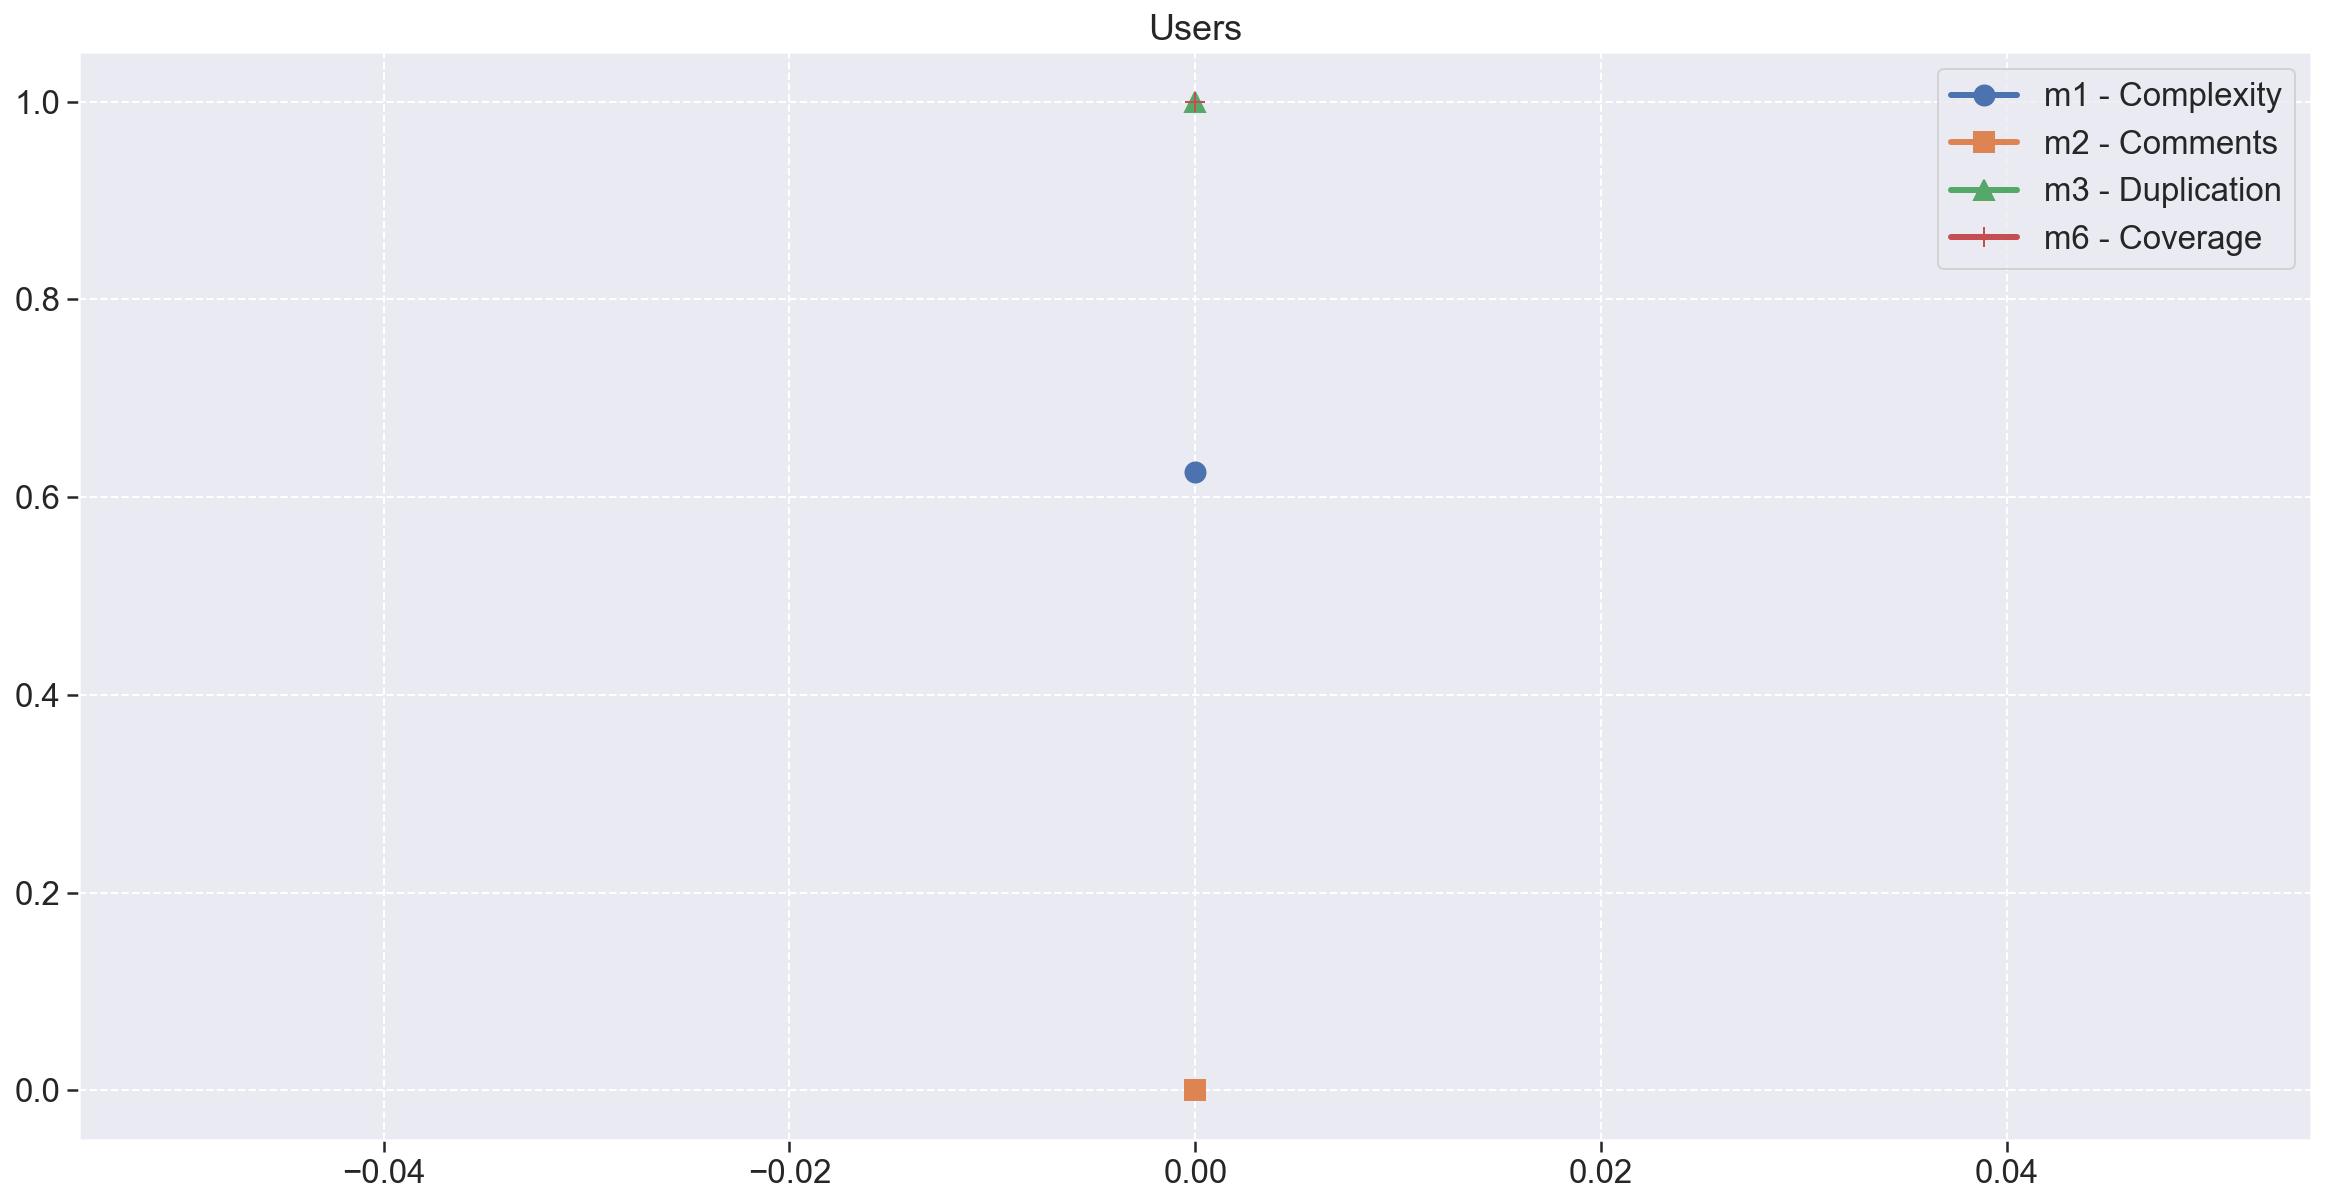

In [22]:
fig = plt.figure(figsize=(20, 10))

plt.title('Users')
plt.plot(users_metrics['m1'], linewidth=3, marker='o', markersize=10, label="m1 - Complexity")
plt.plot(users_metrics['m2'], linewidth=3, marker='s', markersize=10, label="m2 - Comments")
plt.plot(users_metrics['m3'], linewidth=3, marker='^', markersize=10, label="m3 - Duplication")
# plt.plot(users_metrics['m4'], linewidth=3, marker='o', markersize=10, label="m4")
# plt.plot(users_metrics['m5'], linewidth=3, marker='o', markersize=10, label="m5")
plt.plot(users_metrics['m6'], linewidth=3, marker='+', markersize=10, label="m6 - Coverage")

plt.legend(loc='best')

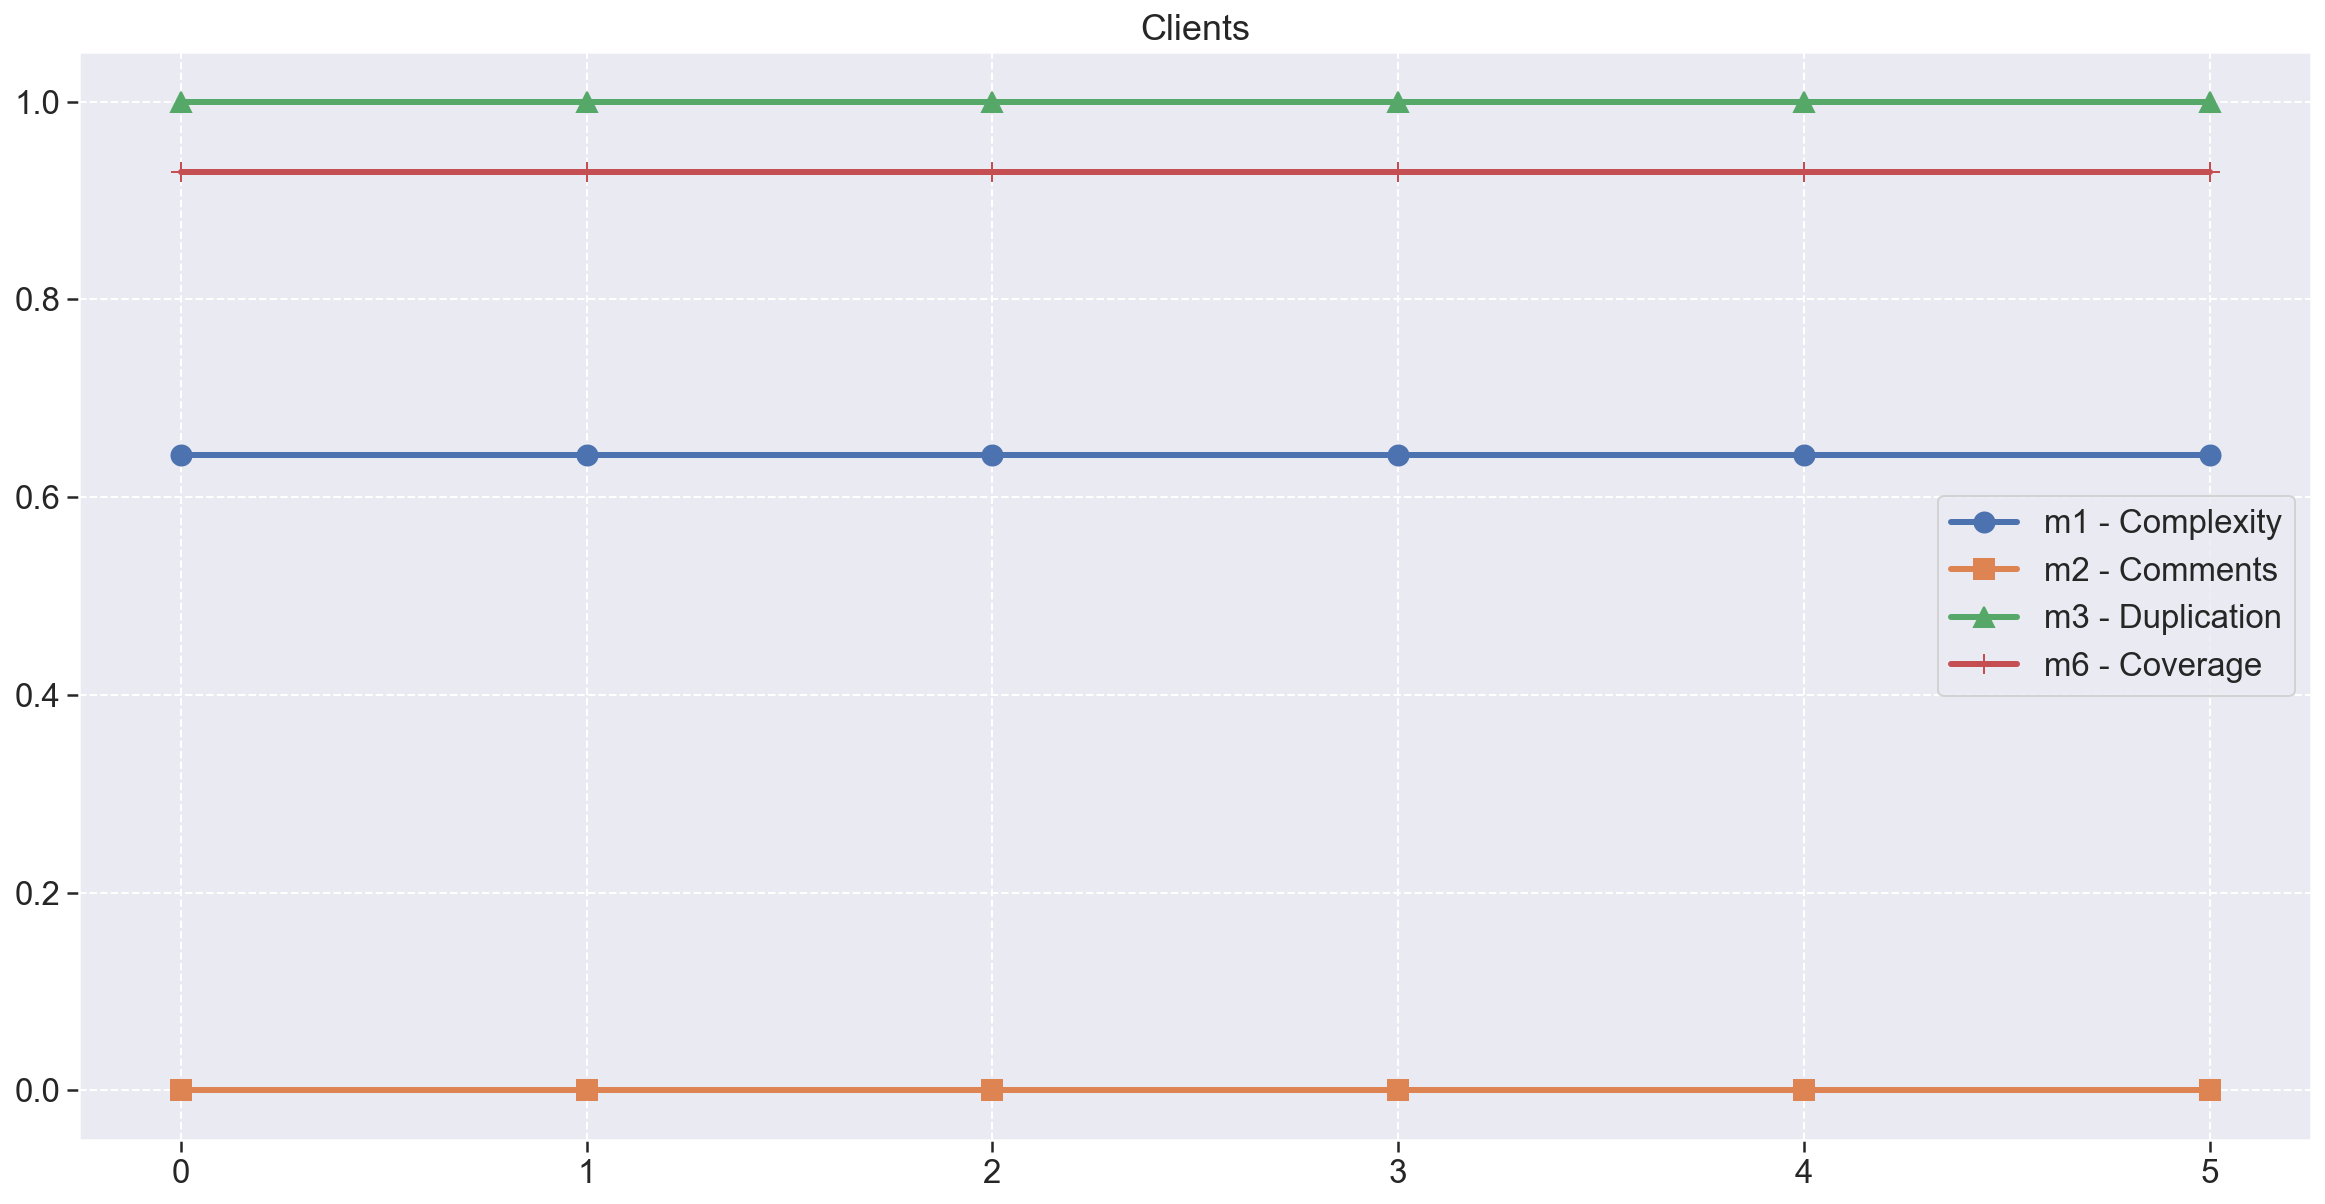

In [23]:
fig = plt.figure(figsize=(20, 10))

plt.title('Clients')
plt.plot(clients_metrics['m1'], linewidth=3, marker='o', markersize=10, label="m1 - Complexity")
plt.plot(clients_metrics['m2'], linewidth=3, marker='s', markersize=10, label="m2 - Comments")
plt.plot(clients_metrics['m3'], linewidth=3, marker='^', markersize=10, label="m3 - Duplication")
# plt.plot(clients_metrics['m4'], linewidth=3, marker='o', markersize=10, label="m4")
# plt.plot(clients_metrics['m5'], linewidth=3, marker='o', markersize=10, label="m5")
plt.plot(clients_metrics['m6'], linewidth=3, marker='+', markersize=10, label="m6 - Coverage")

plt.legend(loc='best')

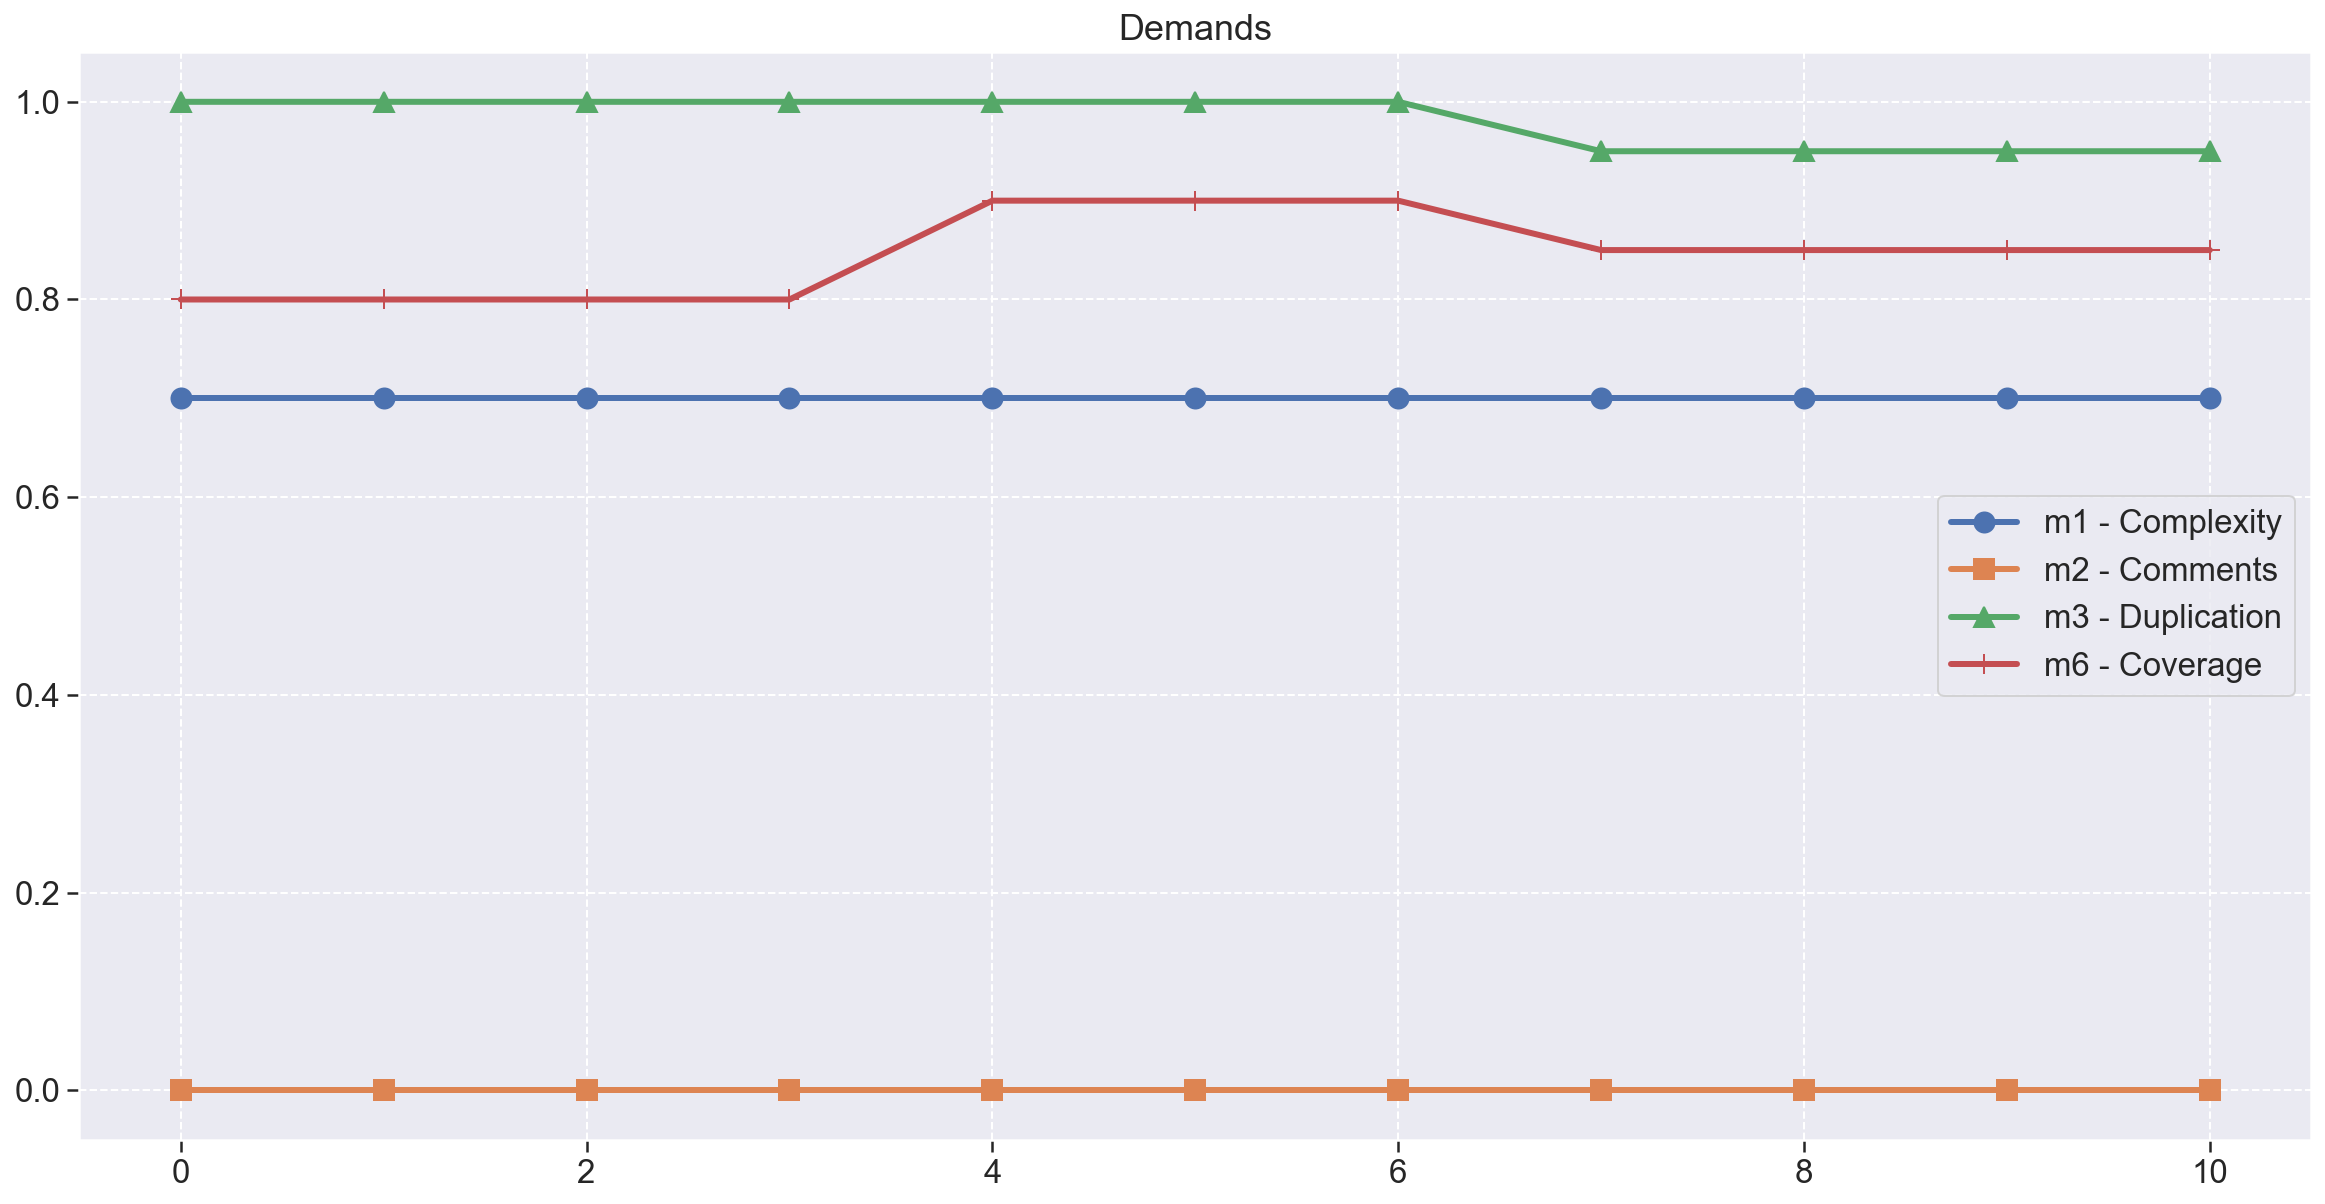

In [24]:
fig = plt.figure(figsize=(20, 10))

plt.title('Demands')
plt.plot(demands_metrics['m1'], linewidth=3, marker='o', markersize=10, label="m1 - Complexity")
plt.plot(demands_metrics['m2'], linewidth=3, marker='s', markersize=10, label="m2 - Comments")
plt.plot(demands_metrics['m3'], linewidth=3, marker='^', markersize=10, label="m3 - Duplication")
# plt.plot(demands_metrics['m4'], linewidth=3, marker='o', markersize=10, label="m4")
# plt.plot(demands_metrics['m5'], linewidth=3, marker='o', markersize=10, label="m5")
plt.plot(demands_metrics['m6'], linewidth=3, marker='+', markersize=10, label="m6 - Coverage")

plt.legend(loc='best')

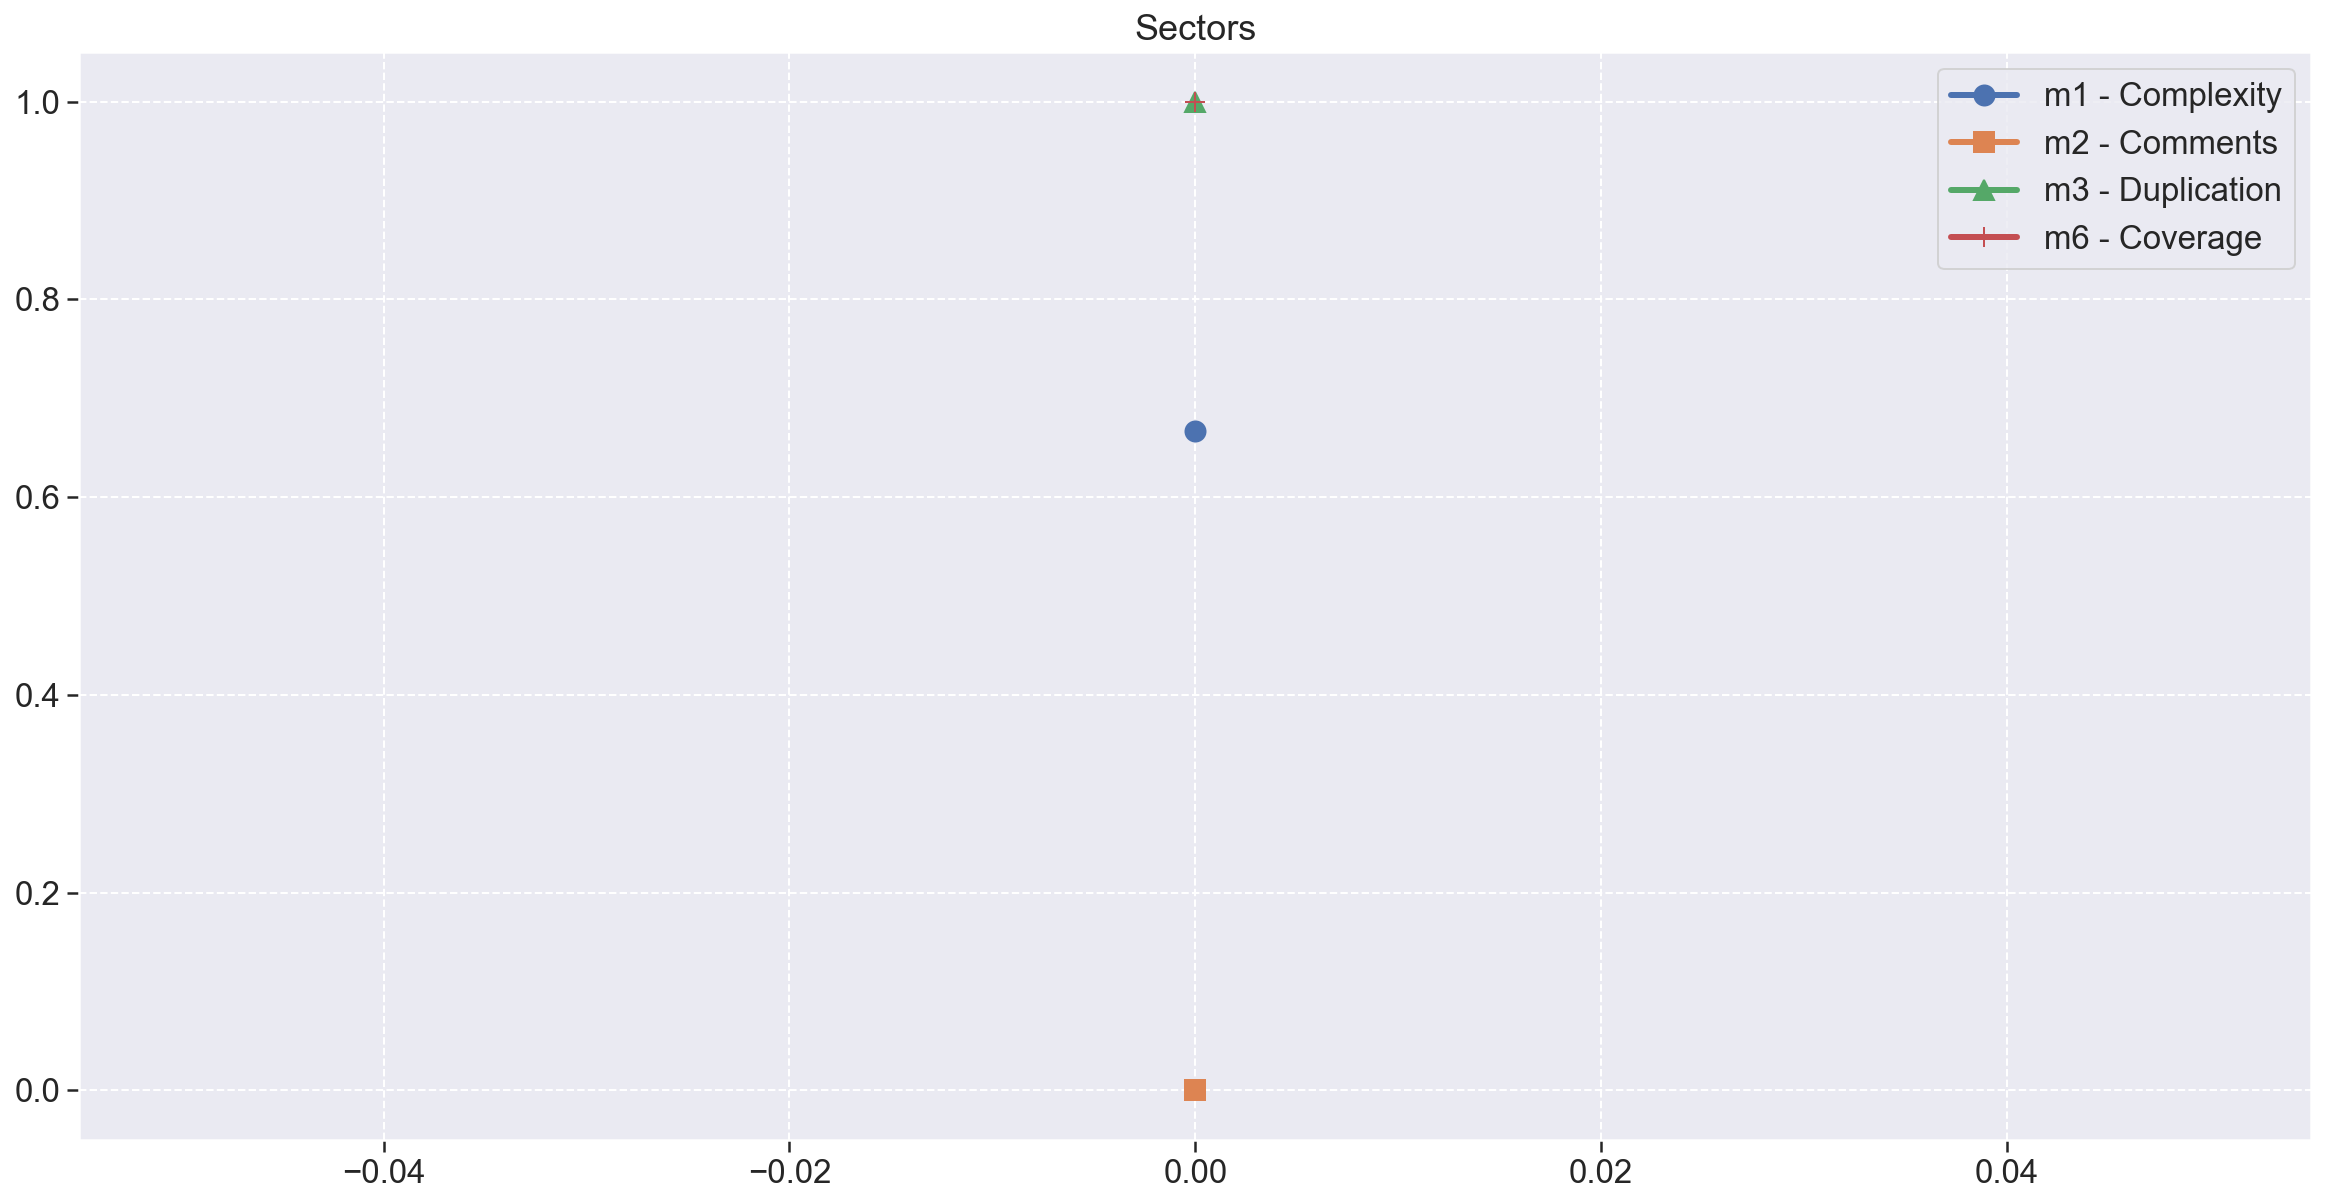

In [25]:
fig = plt.figure(figsize=(20, 10))

plt.title('Sectors')
plt.plot(sectors_metrics['m1'], linewidth=3, marker='o', markersize=10, label="m1 - Complexity")
plt.plot(sectors_metrics['m2'], linewidth=3, marker='s', markersize=10, label="m2 - Comments")
plt.plot(sectors_metrics['m3'], linewidth=3, marker='^', markersize=10, label="m3 - Duplication")
# plt.plot(sectors_metrics['m4'], linewidth=3, marker='o', markersize=10, label="m4")
# plt.plot(sectors_metrics['m5'], linewidth=3, marker='o', markersize=10, label="m5")
plt.plot(sectors_metrics['m6'], linewidth=3, marker='+', markersize=10, label="m6 - Coverage")

plt.legend(loc='best')

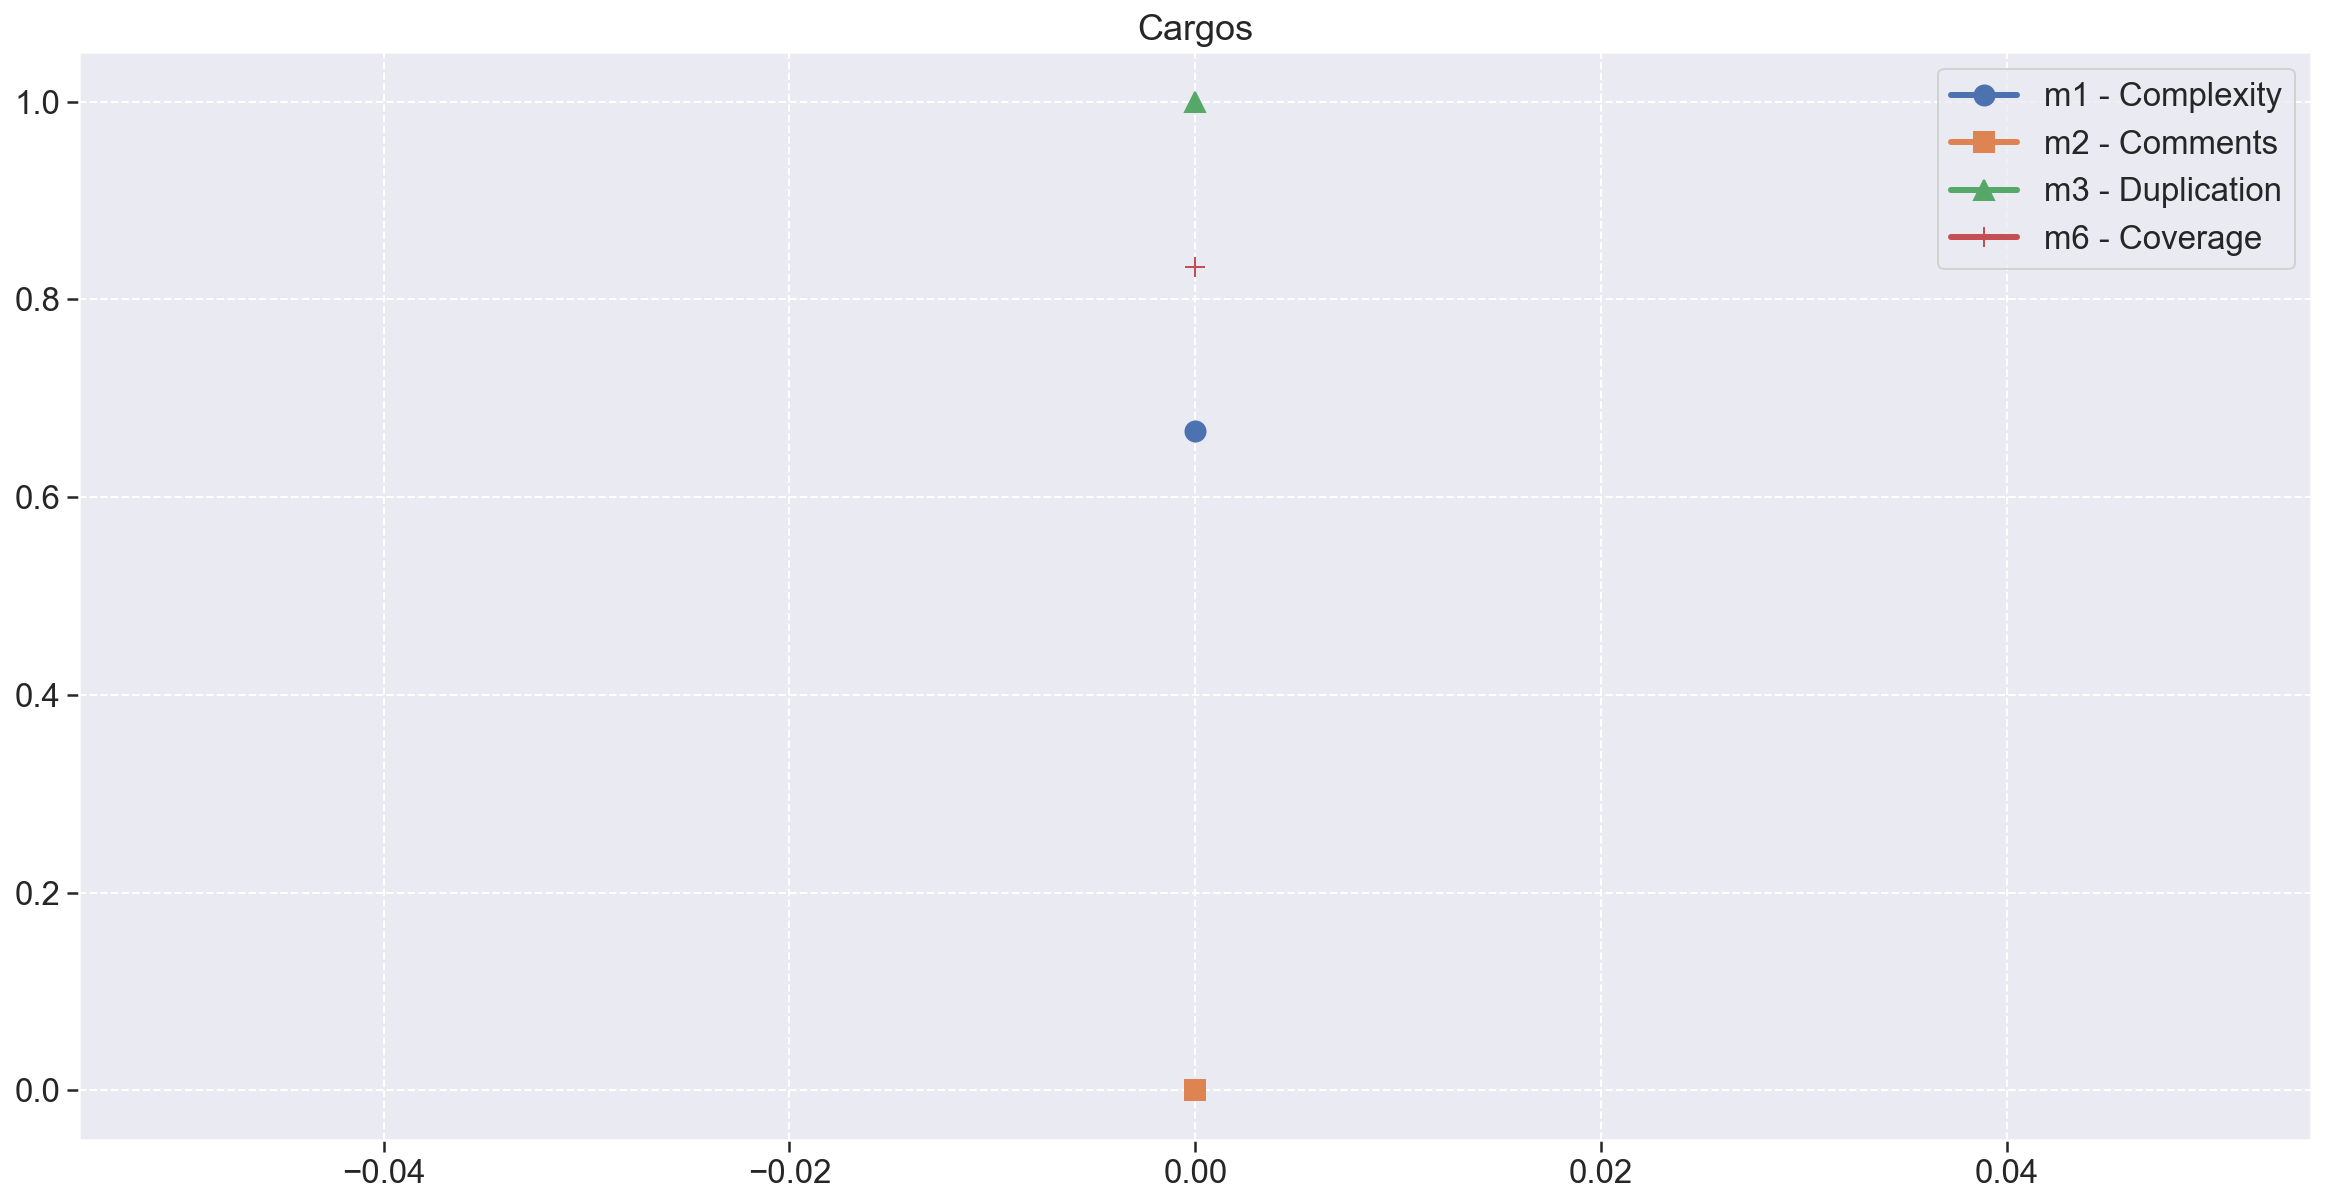

In [26]:
fig = plt.figure(figsize=(20, 10))

plt.title('Cargos')
plt.plot(cargos_metrics['m1'], linewidth=3, marker='o', markersize=10, label="m1 - Complexity")
plt.plot(cargos_metrics['m2'], linewidth=3, marker='s', markersize=10, label="m2 - Comments")
plt.plot(cargos_metrics['m3'], linewidth=3, marker='^', markersize=10, label="m3 - Duplication")
# plt.plot(cargos_metrics['m4'], linewidth=3, marker='o', markersize=10, label="m4")
# plt.plot(cargos_metrics['m5'], linewidth=3, marker='o', markersize=10, label="m5")
plt.plot(cargos_metrics['m6'], linewidth=3, marker='+', markersize=10, label="m6 - Coverage")

plt.legend(loc='best')

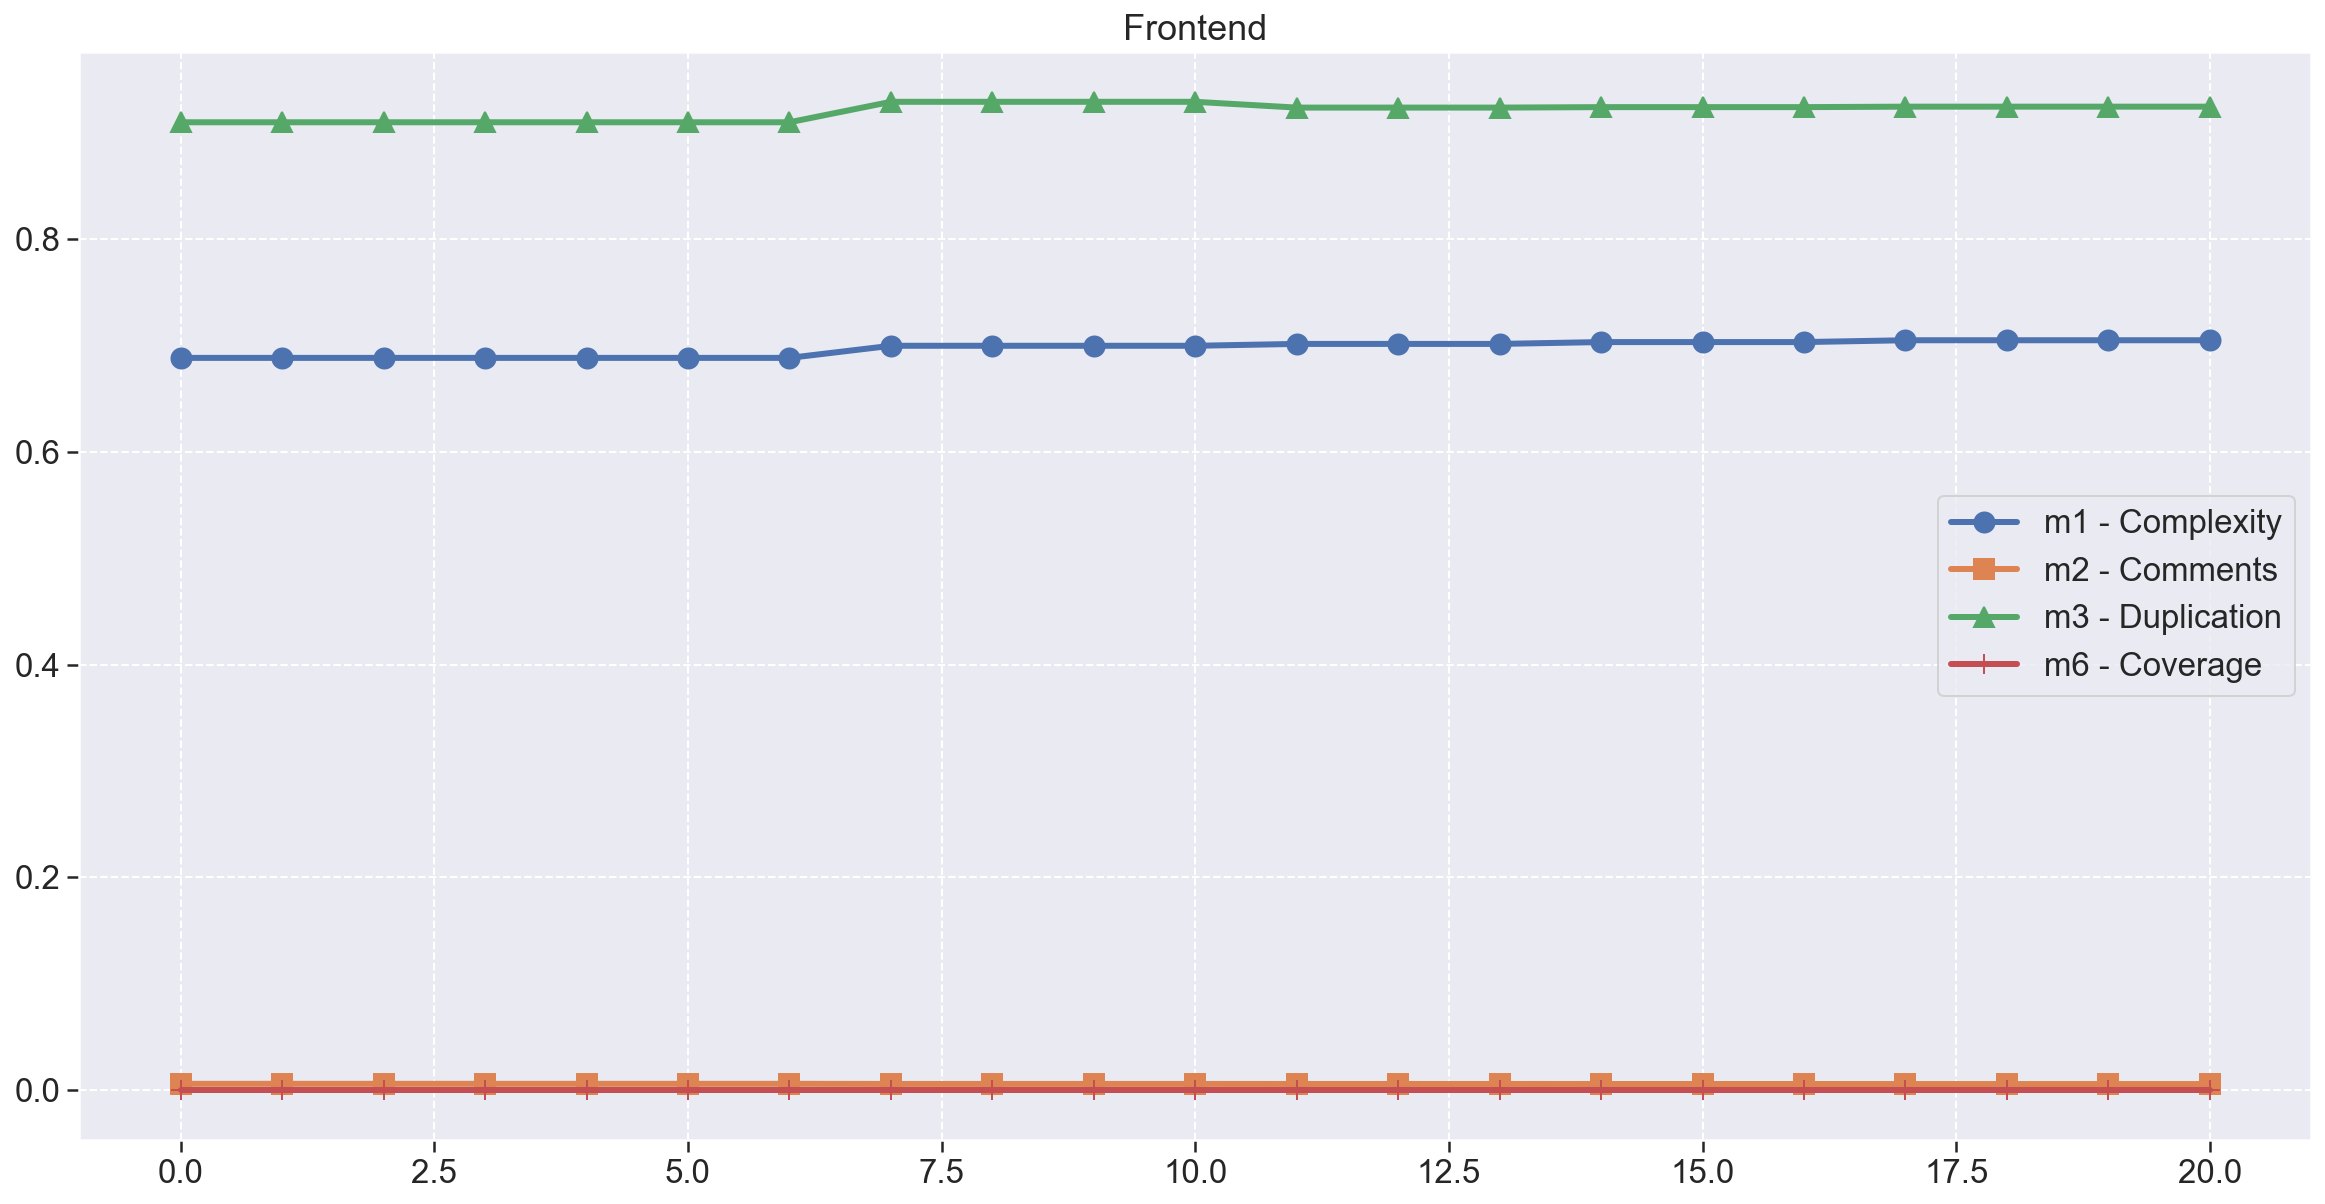

In [27]:
fig = plt.figure(figsize=(20, 10))

plt.title('Frontend')
plt.plot(frontend_metrics['m1'], linewidth=3, marker='o', markersize=10, label="m1 - Complexity")
plt.plot(frontend_metrics['m2'], linewidth=3, marker='s', markersize=10, label="m2 - Comments")
plt.plot(frontend_metrics['m3'], linewidth=3, marker='^', markersize=10, label="m3 - Duplication")
# plt.plot(frontend_metrics['m4'], linewidth=3, marker='o', markersize=10, label="m4")
# plt.plot(frontend_metrics['m5'], linewidth=3, marker='o', markersize=10, label="m5")
plt.plot(frontend_metrics['m6'], linewidth=3, marker='+', markersize=10, label="m6 - Coverage")

plt.legend(loc='best')

### Sub characteristic aggregation

- You must do this for each of your repositories

In [28]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.15
pm5 = 0.15
pm6 = 0.7

users_metrics['code_quality'] = ((users_metrics['m1']*pm1) + (users_metrics['m2']*pm2) + (users_metrics['m3']*pm3)) * psc1
clients_metrics['code_quality'] = ((clients_metrics['m1']*pm1) + (clients_metrics['m2']*pm2) + (clients_metrics['m3']*pm3)) * psc1
demands_metrics['code_quality'] = ((demands_metrics['m1']*pm1) + (demands_metrics['m2']*pm2) + (demands_metrics['m3']*pm3)) * psc1
sectors_metrics['code_quality'] = ((sectors_metrics['m1']*pm1) + (sectors_metrics['m2']*pm2) + (sectors_metrics['m3']*pm3)) * psc1
cargos_metrics['code_quality'] = ((cargos_metrics['m1']*pm1) + (cargos_metrics['m2']*pm2) + (cargos_metrics['m3']*pm3)) * psc1
frontend_metrics['code_quality'] = ((frontend_metrics['m1']*pm1) + (frontend_metrics['m2']*pm2) + (frontend_metrics['m3']*pm3)) * psc1

users_metrics['testing_status'] = users_metrics['m6'] * psc2
clients_metrics['testing_status'] = clients_metrics['m6'] * psc2
demands_metrics['testing_status'] = demands_metrics['m6'] * psc2
sectors_metrics['testing_status'] = sectors_metrics['m6'] * psc2
cargos_metrics['testing_status'] = cargos_metrics['m6'] * psc2
frontend_metrics['testing_status'] = frontend_metrics['m6'] * psc2

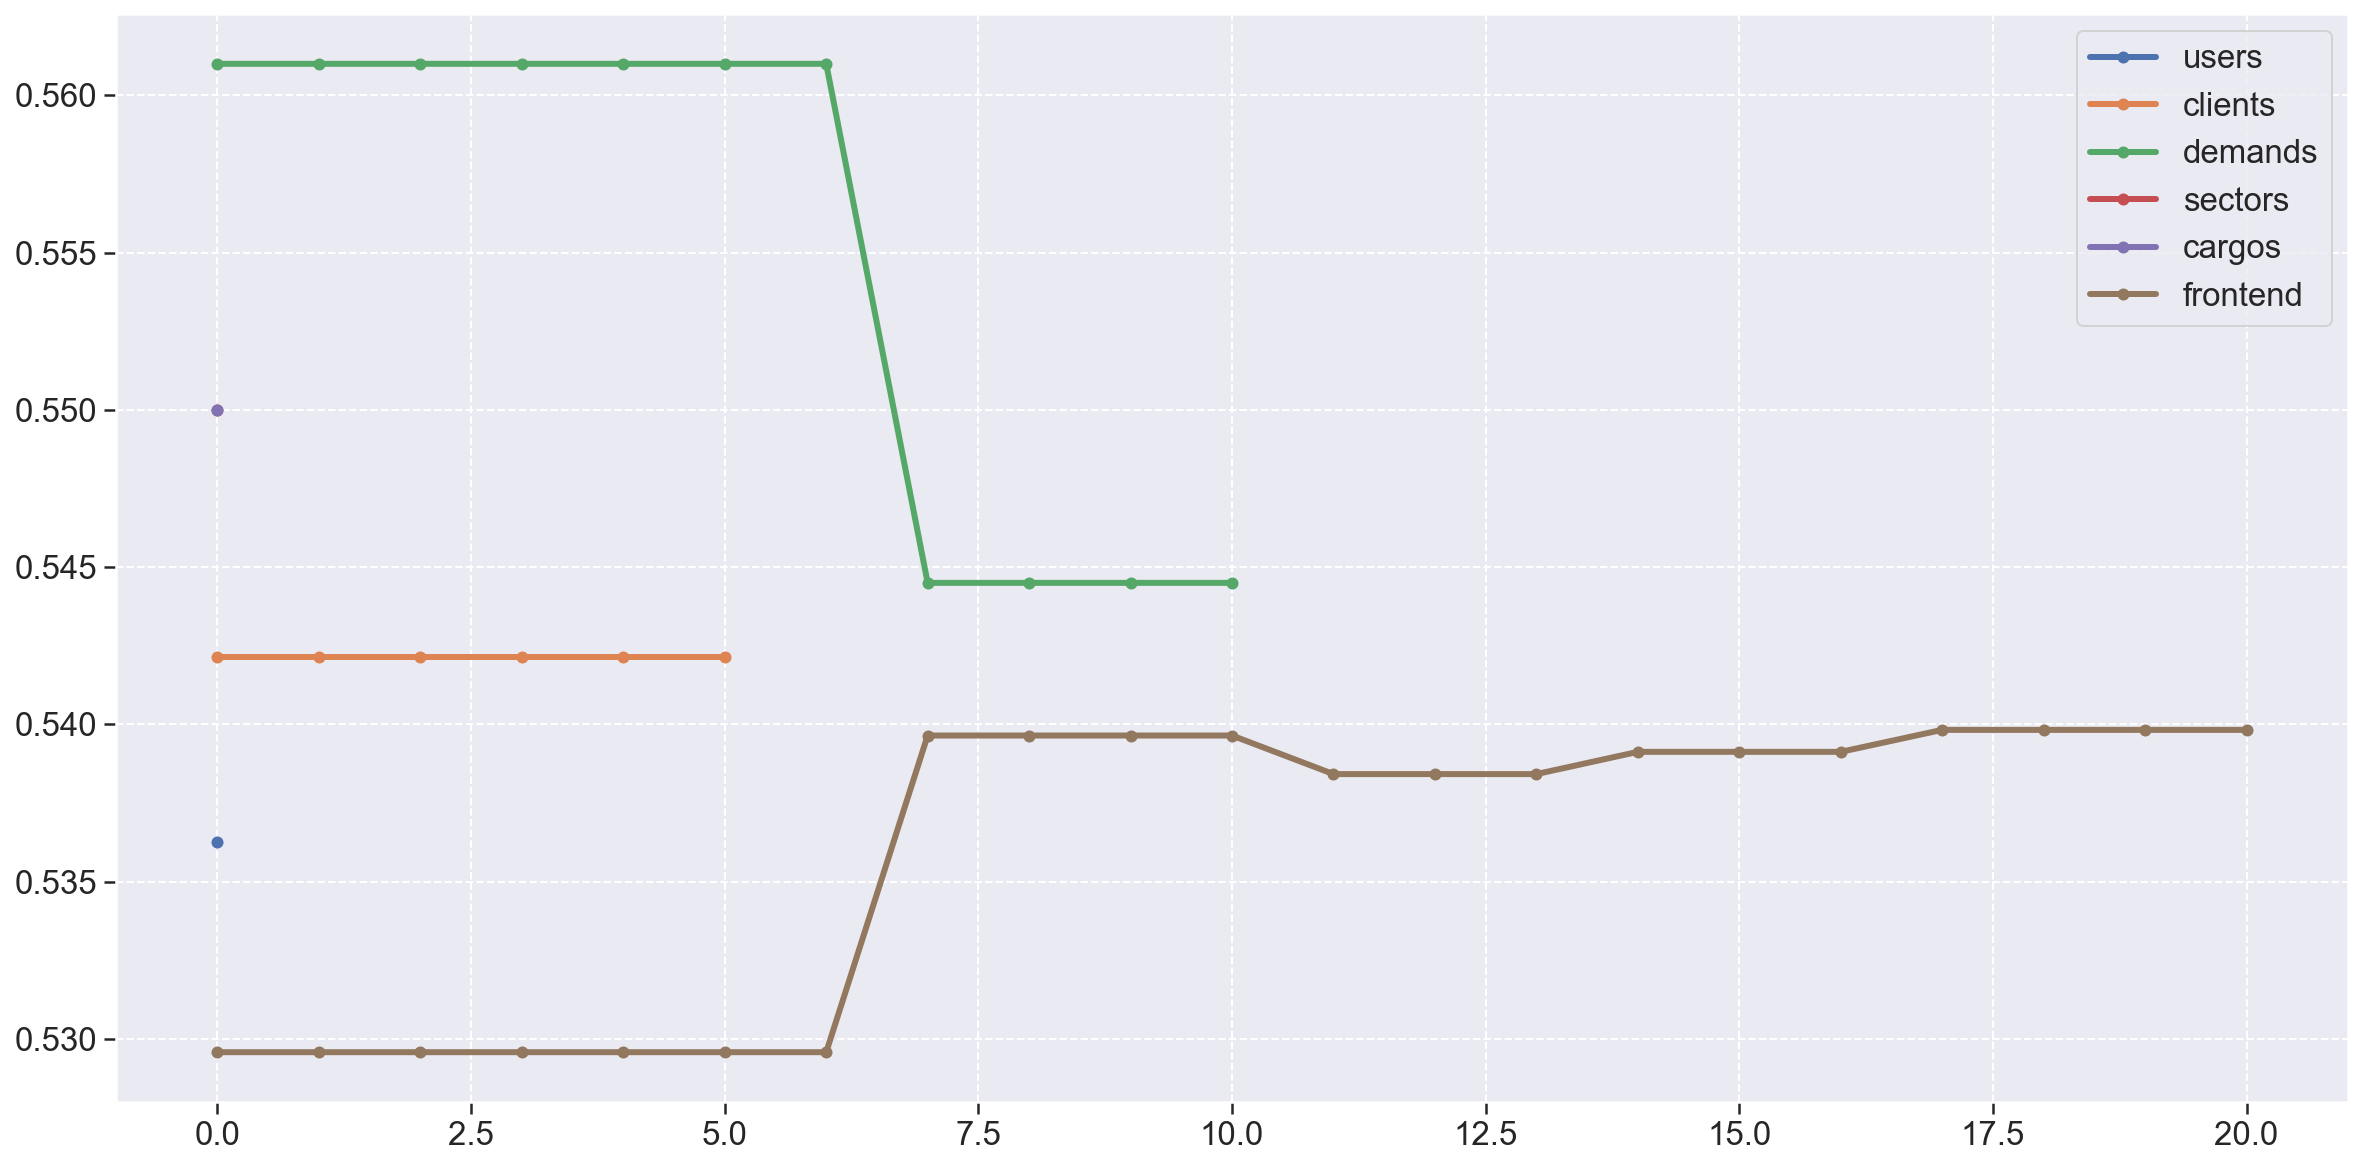

In [29]:
fig = plt.figure(figsize=(20, 10))


plt.plot(users_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label="users")
plt.plot(clients_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label="clients")
plt.plot(demands_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label="demands")
plt.plot(sectors_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label="sectors")
plt.plot(cargos_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label="cargos")
plt.plot(frontend_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label="frontend")


plt.legend(loc='best')

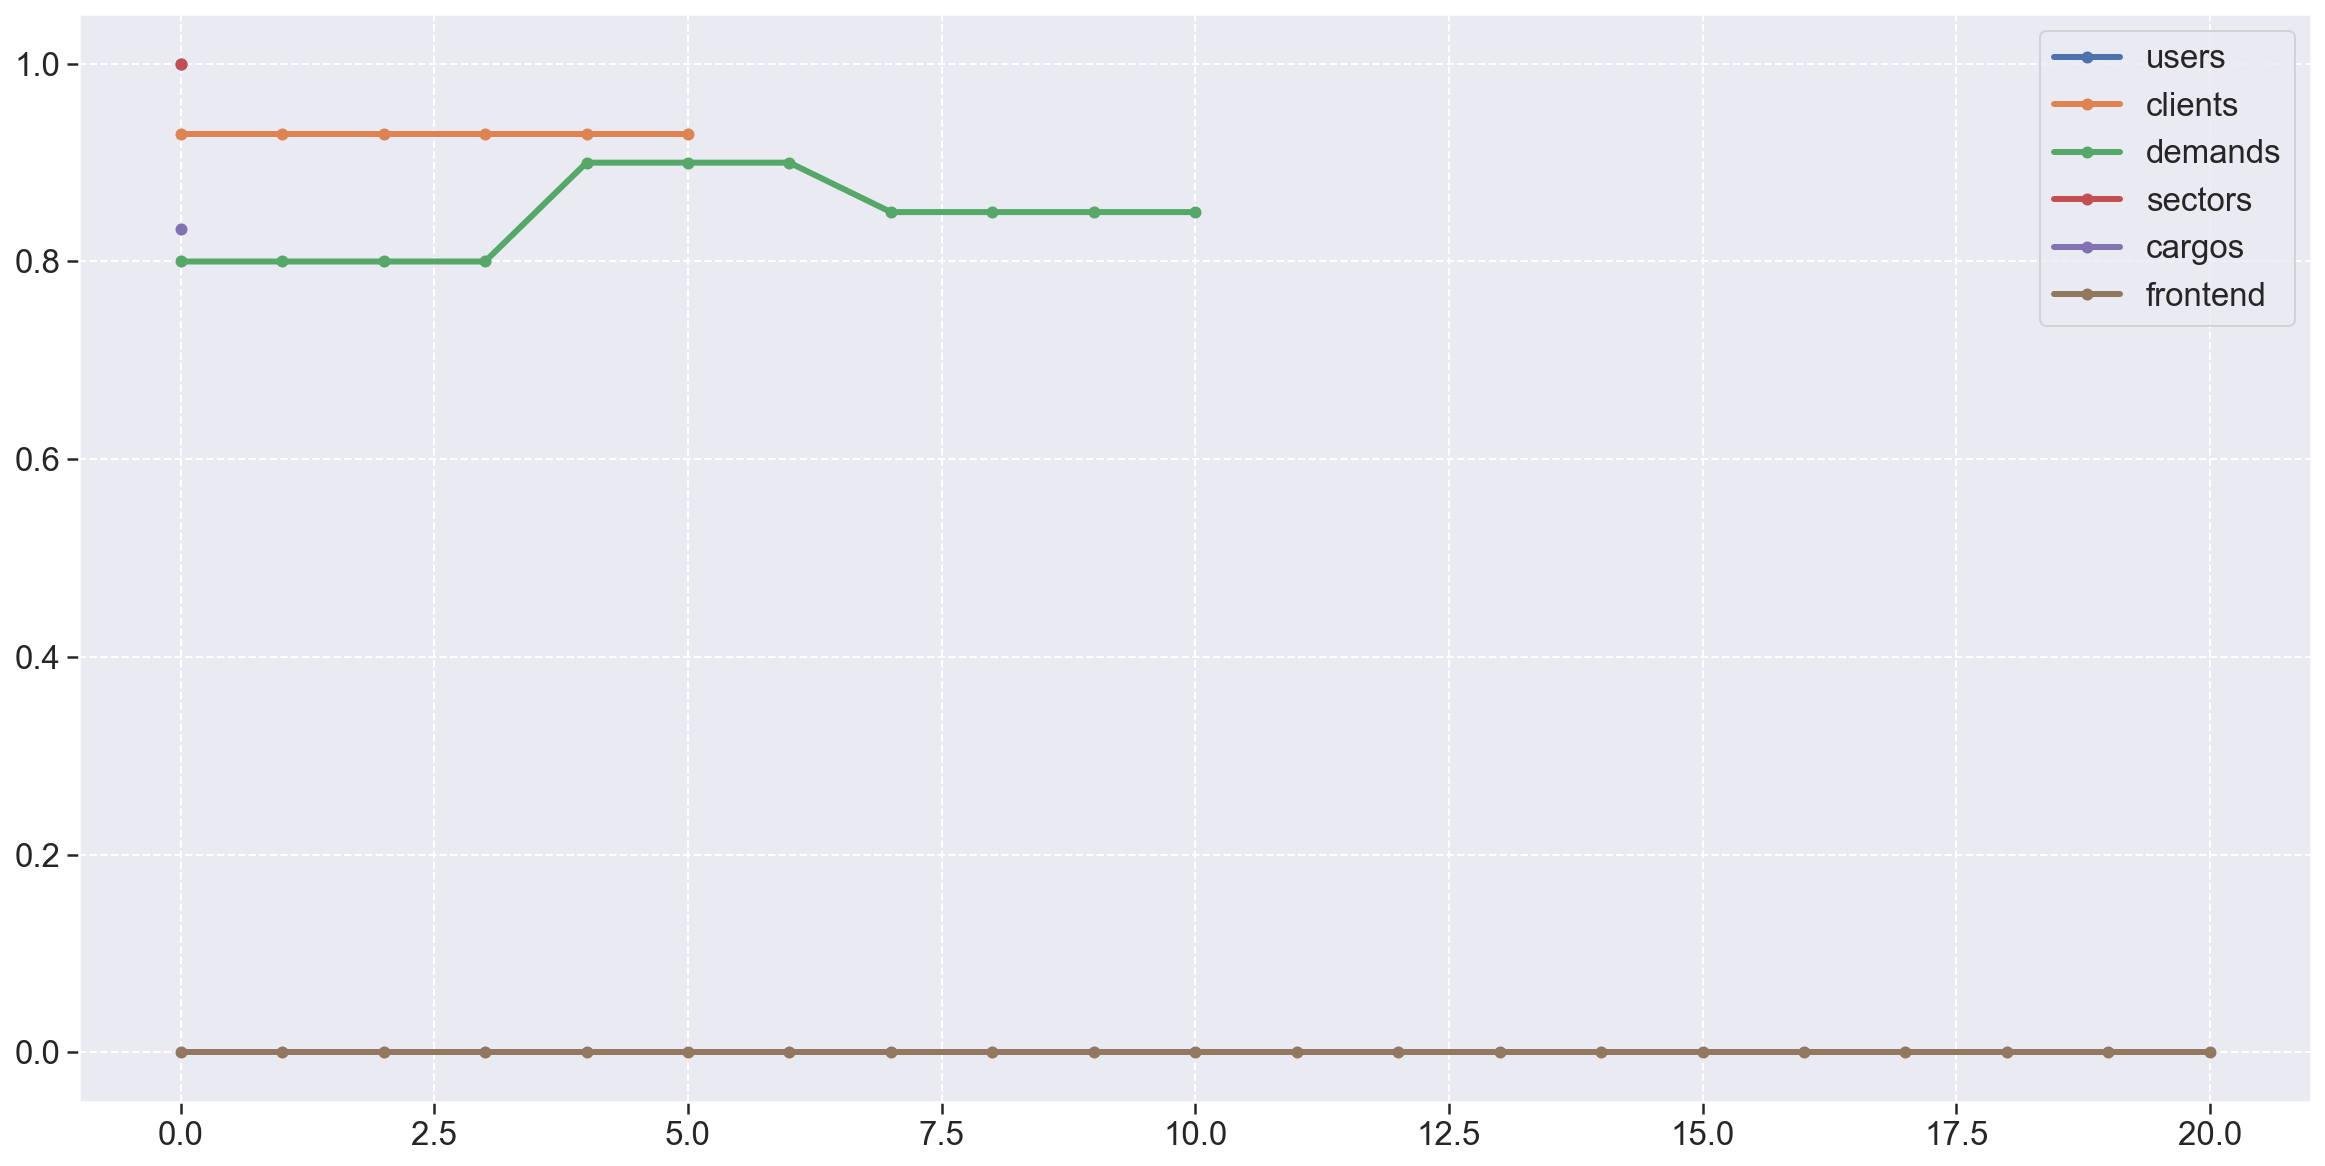

In [30]:
fig = plt.figure(figsize=(20, 10))


plt.plot(users_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label="users")
plt.plot(clients_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label="clients")
plt.plot(demands_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label="demands")
plt.plot(sectors_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label="sectors")
plt.plot(cargos_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label="cargos")
plt.plot(frontend_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label="frontend")


plt.legend(loc='best')

In [31]:
metrics_df = pd.concat([users_metrics, clients_metrics, demands_metrics, sectors_metrics, cargos_metrics, frontend_metrics], ignore_index=True)

metrics_df['Maintainability'] = metrics_df['code_quality'] * pc1
metrics_df['Reliability'] = metrics_df['testing_status'] * pc2
metrics_df['Total_QR'] = metrics_df['Maintainability'] + metrics_df['Reliability']

In [32]:
metrics_df

,m1,m2,m3,m6,LOC,Repository,Version,Date,code_quality,testing_status,Maintainability,Reliability,Total_QR
0,0.625000,0.000000,1.000000,1.000000,324,Users,3.0.0,03-18-2022-23:31:12,0.536250,1.000000,0.268125,0.500000,0.768125
1,0.642857,0.000000,1.000000,0.928571,705,Clients,2.1.0,03-16-2022-06:44:01,0.542143,0.928571,0.271071,0.464286,0.735357
2,0.642857,0.000000,1.000000,0.928571,705,Clients,2.2.0,03-16-2022-06:44:32,0.542143,0.928571,0.271071,0.464286,0.735357
3,0.642857,0.000000,1.000000,0.928571,751,Clients,3.0.0,03-18-2022-22:54:01,0.542143,0.928571,0.271071,0.464286,0.735357
4,0.642857,0.000000,1.000000,0.928571,751,Clients,3.1.0,03-18-2022-22:54:14,0.542143,0.928571,0.271071,0.464286,0.735357
5,0.642857,0.000000,1.000000,0.928571,751,Clients,4.0.0,04-13-2022-05:39:01,0.542143,0.928571,0.271071,0.464286,0.735357
6,0.642857,0.000000,1.000000,0.928571,751,Clients,4.1.0,04-13-2022-05:47:18,0.542143,0.928571,0.271071,0.464286,0.735357
7,0.700000,0.000000,1.000000,0.800000,1436,Demands,2.6.0,03-03-2022-03:38:14,0.561000,0.800000,0.280500,0.400000,0.680500
8,0.700000,0.000000,1.000000,0.800000,1436,Demands,2.7.0,03-03-2022-03:38:42,0.561000,0.800000,0.280500,0.400000,0.680500
9,0.700000,0.000000,1.000000,0.800000,1437,Demands,2.8.0,03-16-2022-02:16:40,0.561000,0.800000,0.280500,0.400000,0.680500


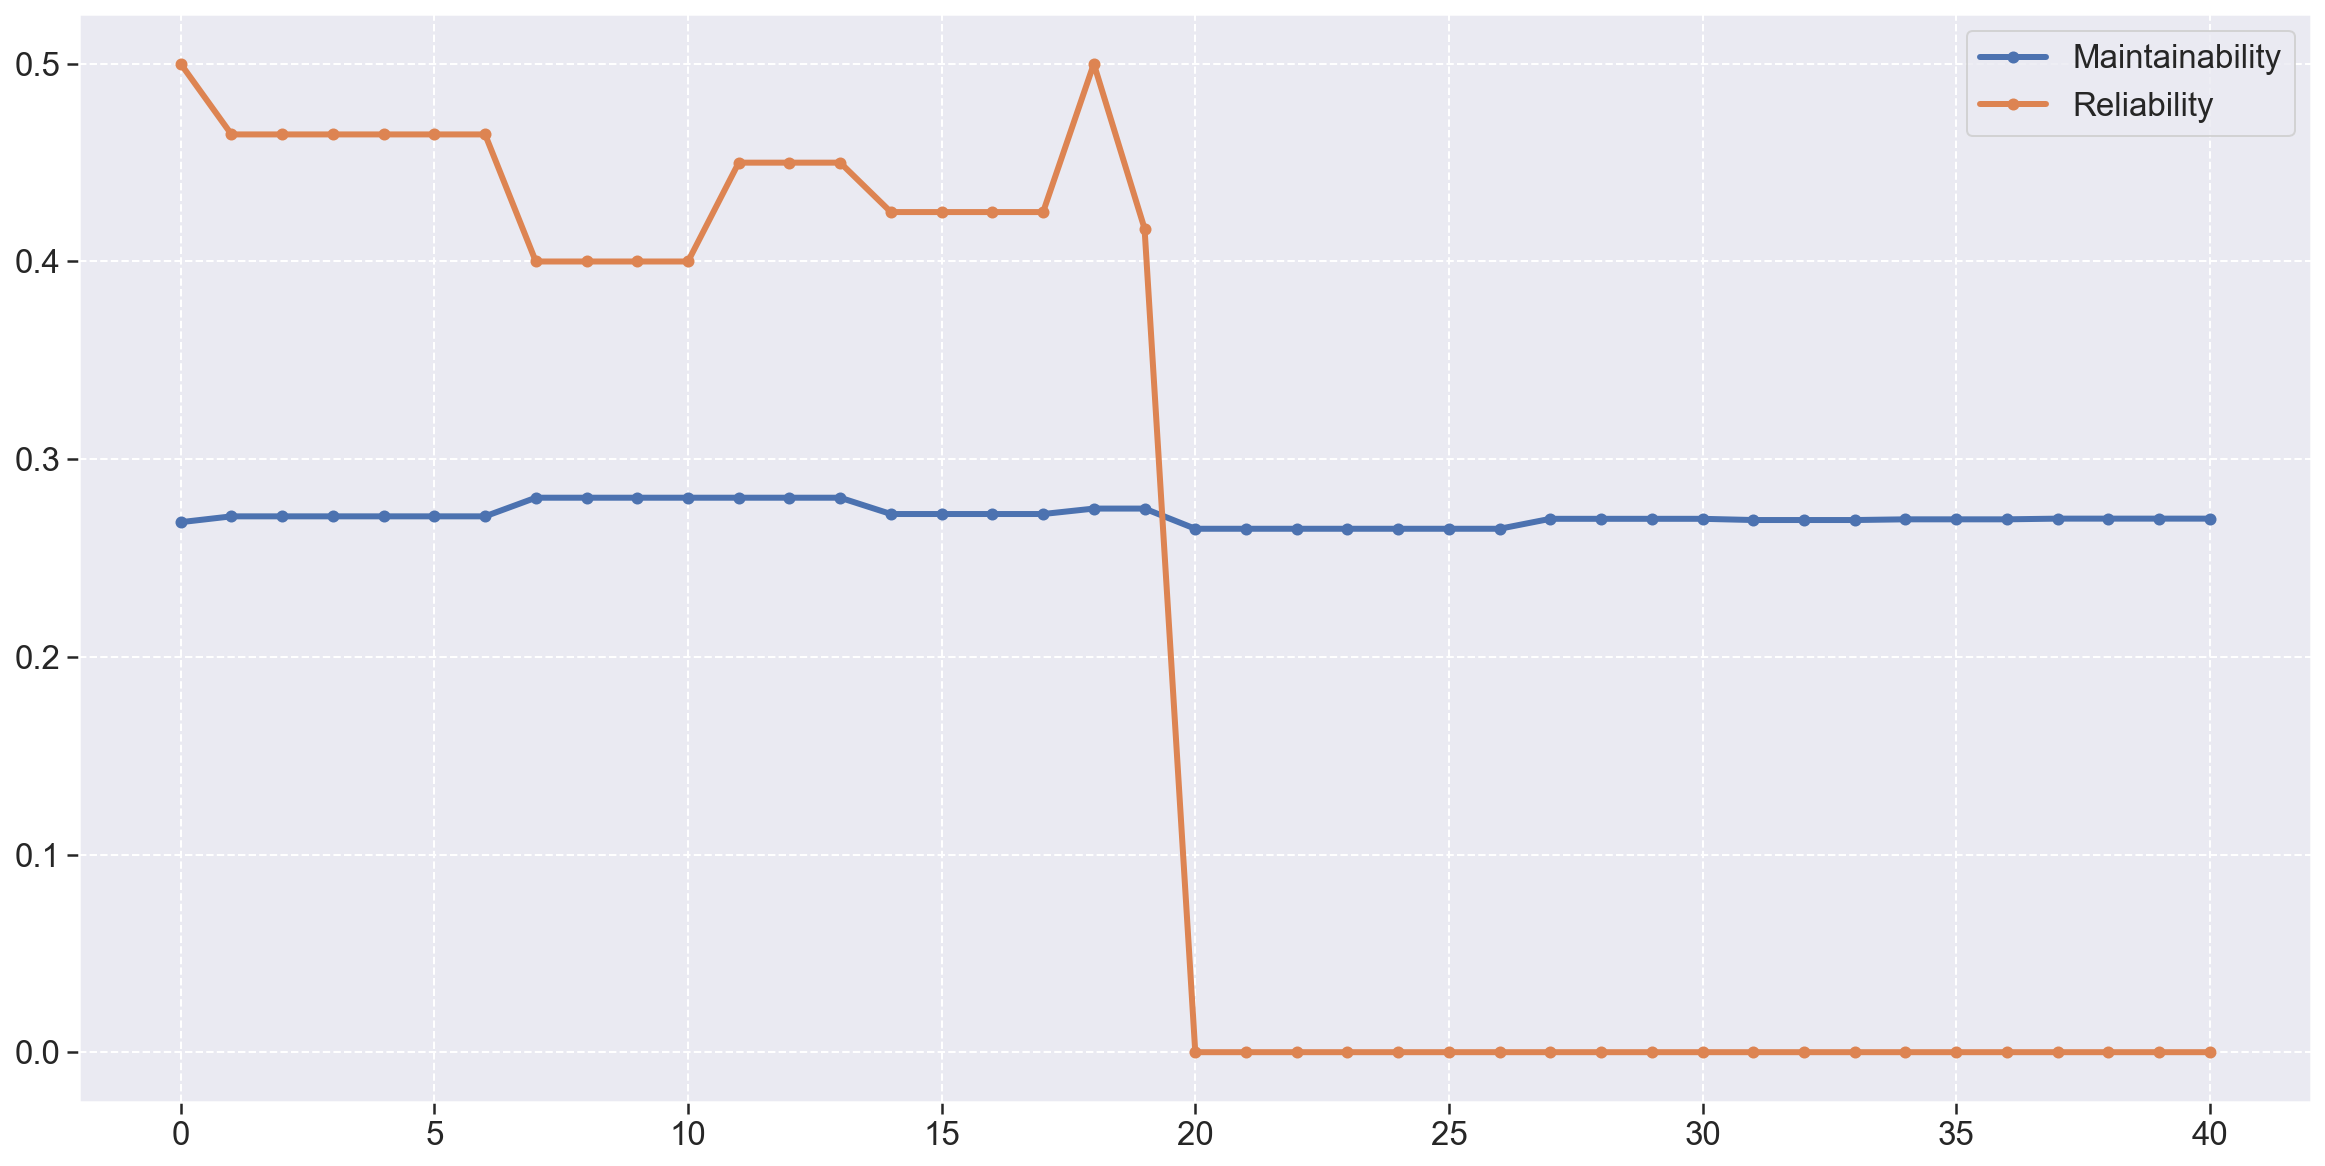

In [33]:
fig = plt.figure(figsize=(20, 10))

plt.plot(metrics_df['Maintainability'], linewidth=3, marker='o', markersize=5, label="Maintainability")
plt.plot(metrics_df['Reliability'], linewidth=3, marker='o', markersize=5, label="Reliability")
plt.legend(loc='best')

#plt.ylim(.45,.7)

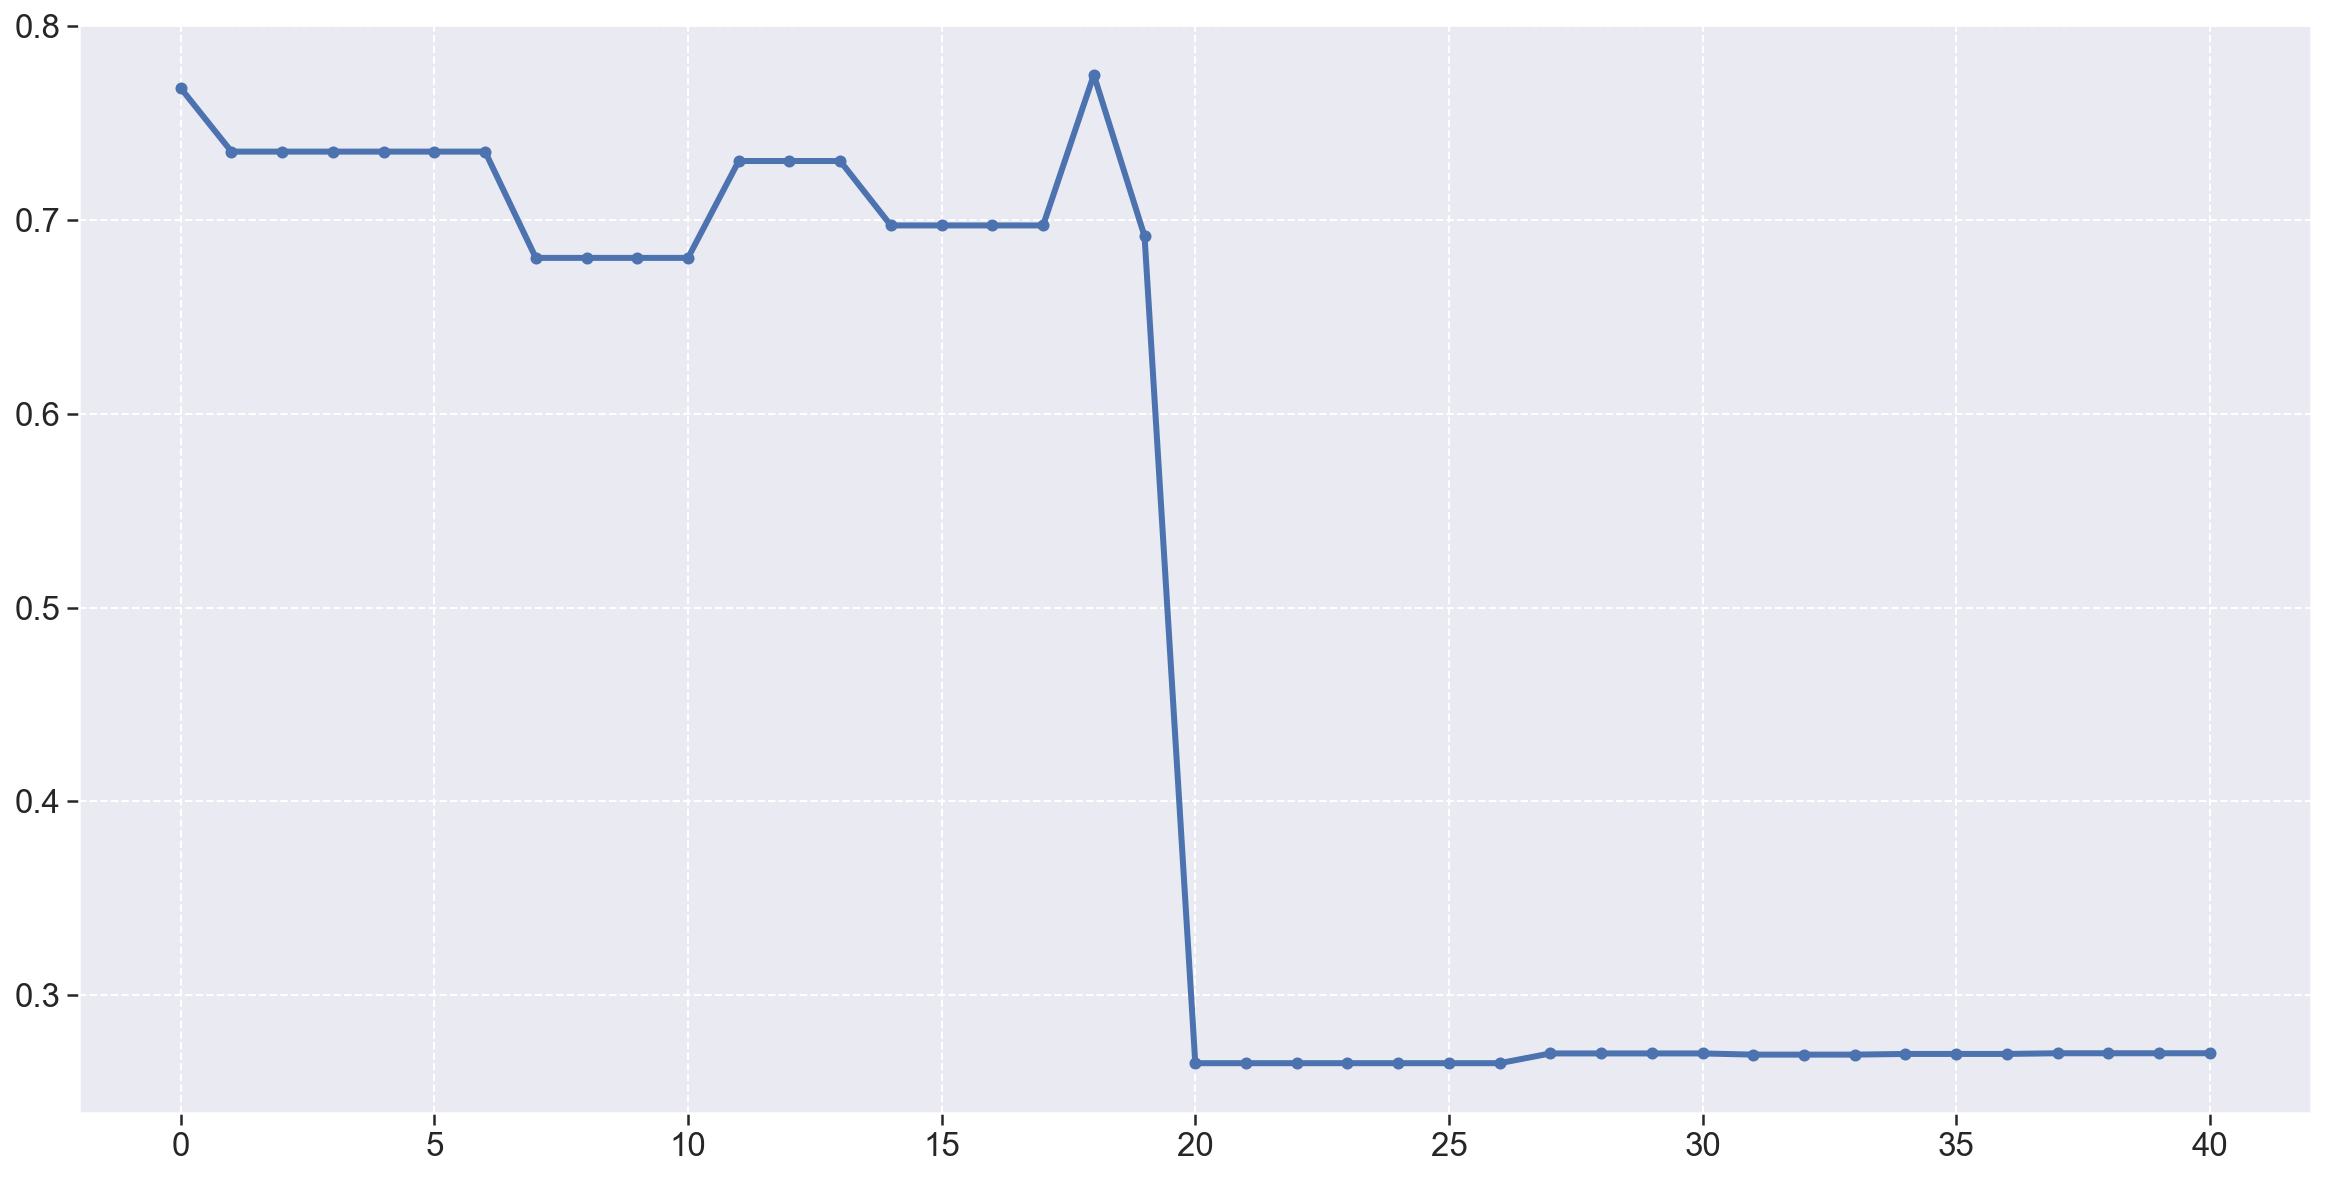

In [34]:
fig = plt.figure(figsize=(20, 10))

plt.plot(metrics_df['Total_QR'], linewidth=3, marker='o', markersize=5)

#plt.ylim(.45,.7)

In [35]:
# DATE FORMAT: MM-DD-YYYY-HH:MM:SS
currentDateTime = datetime.datetime.now().strftime("%m-%d-%Y-%H:%M:%S")

metrics_df.to_excel('fga-eps-mds-2021_02-SiGeD-NOME_REPOSITORIO{}-VERSAO_RELEASE.xlsx'.format(currentDateTime), index = False)
metrics_df.to_csv('fga-eps-mds-2021_02-SiGeD-NOME_REPOSITORIO-{}-VERSAO_RELEASE.csv'.format(currentDateTime), index = False)